In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedStratifiedKFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, get_scorer_names
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import plot_tree, DecisionTreeClassifier, export_graphviz
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import random
from numpy import log
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder

In [48]:
train_set = pd.read_csv('../Comp/education-attainment-prediction-2025/CENSUS_ED_ATTN.csv')
test_set = pd.read_csv('../Comp/education-attainment-prediction-2025/Census_Test.csv')

A_HGA is our target variable

In [49]:
def clean_split_data(df, target, train_size=0.75, tune_size=0.15, random_state=21):
    X = df.drop(columns=['A_HGA']) 
    X[['PENATVTY', 'PEFNTVTY', 'PRDTRACE']] = X[['PENATVTY', 'PEFNTVTY', 'PRDTRACE']].astype('category')
    
    y = df[target].astype('category')

    # Split data into training and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, stratify=y, random_state=random_state)
    
    # Split the temporary set into tuning and testing sets
    X_tune, X_test, y_tune, y_test = train_test_split(X_temp, y_temp, train_size=tune_size, stratify=y_temp, random_state=random_state+28)
    
    return X_train, X_tune, X_test, y_train, y_tune, y_test

# Use the function to split the movie data
X_train, X_tune, X_test, y_train, y_tune, y_test = clean_split_data(train_set, 'A_HGA')

In [51]:
kf = RepeatedStratifiedKFold(n_splits=10, n_repeats =5, random_state=42)

In [52]:
scoring = ['accuracy', 'recall_macro', 'balanced_accuracy', 'f1_macro']
#only go to 5, because everything after is diminishing returns
param={"max_depth" : [1,2,3,4,5,6,7,8,9,10],
           }

In [53]:
#cl= DecisionTreeClassifier(random_state=1000, class_weight='balanced')
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=1000, n_jobs=-1, class_weight='balanced')
#search = GridSearchCV(clf, param, scoring=scoring, n_jobs=1, cv=kf, refit='balanced_accuracy', return_train_score=True)
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "max_depth": [4, 6, 8, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}
search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=1000, class_weight='balanced'),
    param_distributions=param_dist,
    n_iter=20,  # number of random combinations to try
    scoring = ['accuracy', 'recall_macro', 'balanced_accuracy', 'f1_macro'],
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    random_state=42,
    refit='balanced_accuracy'
)


In [ ]:
model = search.fit(X_train, y_train)

In [55]:
best= model.best_estimator_
print(best)

#plt.figure(figsize=(20,10))
#plot_tree(best, feature_names=X_train.columns, class_names=[str(label) for label in y_train.unique()], filled=True, rounded=True)
#plt.show()

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=10, random_state=1000)


   depth  accuracy    recall   bal_acc        f1  accuracySD  recallSD  \
0      4  0.328556  0.249119  0.249119  0.173073    0.001877  0.003851   
1      6  0.320648  0.239716  0.239716  0.160629    0.007628  0.005048   
2      8  0.325349  0.243420  0.243420  0.168020    0.005652  0.004100   
3     10  0.328952  0.249984  0.249984  0.173817    0.001486  0.004311   

   bal_accSD      f1SD  
0   0.003851  0.002705  
1   0.005048  0.003397  
2   0.004100  0.002910  
3   0.004311  0.002549  


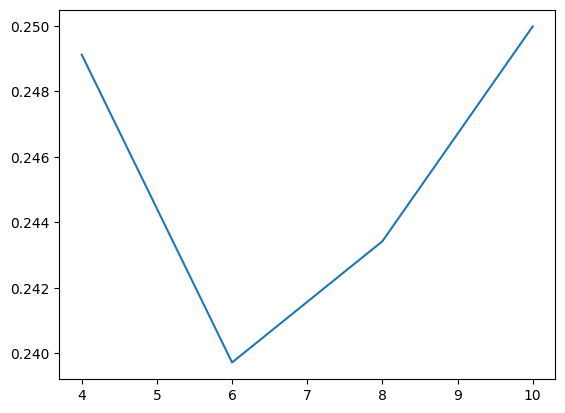

In [56]:
np.random.seed(1)
accuracy = model.cv_results_['mean_test_accuracy']
recall = model.cv_results_['mean_test_recall_macro']
bal_acc = model.cv_results_['mean_test_balanced_accuracy']
f1 = model.cv_results_['mean_test_f1_macro']

SDaccuracy = model.cv_results_['std_test_accuracy']
SDrecall = model.cv_results_['std_test_recall_macro']
SDbal_acc = model.cv_results_['std_test_balanced_accuracy']
SDf1 = model.cv_results_['std_test_f1_macro']

depth = np.unique(model.cv_results_['param_max_depth']).data

final_model = pd.DataFrame(list(zip(depth, accuracy, recall, bal_acc, f1, SDaccuracy, SDrecall, SDbal_acc, SDf1)),
               columns=['depth', 'accuracy', 'recall', 'bal_acc', 'f1', 'accuracySD', 'recallSD', 'bal_accSD', 'f1SD'])

print(final_model)
plt.plot(final_model['depth'], final_model['bal_acc'], label='Accuracy')

           importance
WSAL_VAL     0.156921
PEAFEVER     0.154378
PARENT       0.106359
PENATVTY     0.094009
PEINUSYR     0.084074
PEFNTVTY     0.074363
A_MARITL     0.065531
PEPAR1TYP    0.064166
PRCITSHP     0.058051
ERN_SRCE     0.054391
PRDTRACE     0.032271
PEHSPNON     0.031508
A_SEX        0.019533
ANN_VAL      0.004445


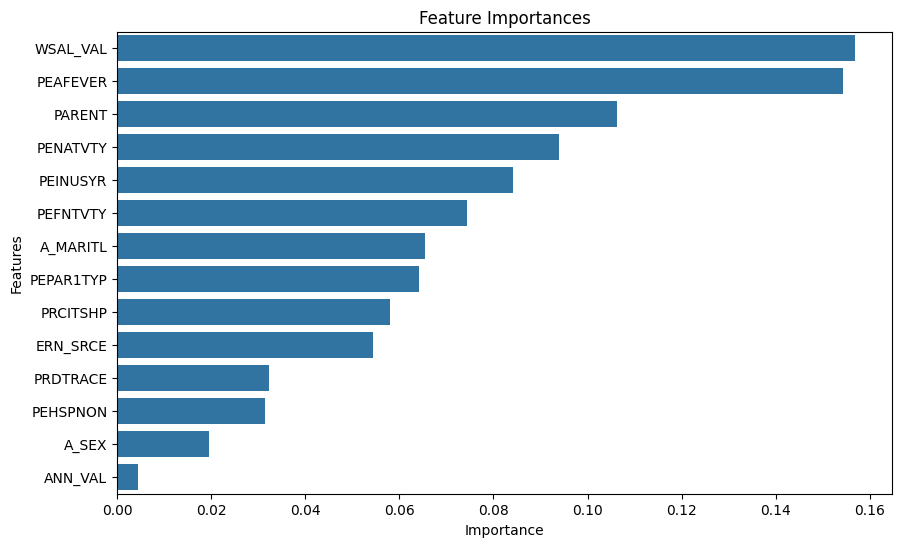

In [57]:
varimp = pd.DataFrame(best.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(varimp)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=varimp['importance'], y=varimp.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [58]:
tune_predictions = pd.DataFrame(model.predict(X_tune), columns=['Predicted_Label']) 

percentages = tune_predictions['Predicted_Label'].value_counts(normalize=True) * 100

# Convert to a table format
table = percentages.reset_index()
table.columns = ['Label', 'Percentage']

# Print the table
print("Percentage of Each Predicted Label:")
print(table)

Percentage of Each Predicted Label:
    Label  Percentage
0      45   31.722320
1      33   24.868190
2      32   14.815466
3      44   11.898067
4      39    6.731107
5      42    3.286467
6      31    2.126538
7      36    1.493849
8      43    1.247803
9      37    1.230228
10     40    0.421793
11     46    0.140598
12     38    0.017575


/home/vscode/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [59]:
from sklearn.metrics import precision_score, classification_report

# Predict on test set using best estimator
y_pred = search.best_estimator_.predict(X_test)

# Macro precision
macro_prec = precision_score(y_test, y_pred, average='macro')
print(f"Macro Precision on Test Set: {macro_prec:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Macro Precision on Test Set: 0.0834

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      6684
          31     0.0200    0.2055    0.0365        73
          32     0.0029    0.0823    0.0056       158
          33     0.0049    0.1304    0.0094       299
          34     0.0000    0.0000    0.0000       555
          35     0.0000    0.0000    0.0000       695
          36     0.0335    0.0204    0.0253       785
          37     0.4280    0.2270    0.2966       890
          38     0.0000    0.0000    0.0000       451
          39     0.3354    0.0998    0.1538      7067
          40     0.2199    0.0078    0.0151      3958
          41     0.0000    0.0000    0.0000      1035
          42     0.0399    0.0284    0.0332      1372
          43     0.1802    0.0138    0.0256      5155
          44     0.0971    0.1708    0.1239      2254
          45     0.0178    0.5552    0.0344       335
          46     0.03

/home/vscode/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/vscode/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vscode/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vscode/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set t

In [60]:
# Predict the target variable for the test set
#test_set = test_set.drop(columns=['PEAFEVER'])
test_predictions = model.best_estimator_.predict(test_set)

# Add predictions to the test set
test_set.index = test_set.index + 1
test_set.index.name = 'ID'
test_set['A_HGA'] = test_predictions


# Keep only the Predicted_Score and index
test_set = test_set[['A_HGA']]
print(test_set)
# Save the predictions to a CSV file
test_set.to_csv('predictions.csv', index=True, header=True)

     A_HGA
ID        
1       33
2       44
3       44
4       42
5       33
..     ...
981     45
982     39
983     33
984     33
985     33

[985 rows x 1 columns]


/home/vscode/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
